# Anime Face Recoginition with GoogLeNet and Resnet

In [2]:
import zipfile
import os, os.path
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import io
from pathlib import Path
import time
import copy

# import pytorch
import torch
from torch import nn
from torch.nn import Parameter
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, datasets, models

In [1]:
!pip install google-cloud-storage

## Set-up

In [26]:
from google.cloud import storage

# instantiate a client
client = storage.Client()

# get bucket
bucket = client.get_bucket('icartoonface')
# 'personai_icartoonface_rectrain/icartoonface_rectrain/personai_icartoonface_rectrain_00000/personai_icartoonface_rectrain_00000_0000000.jpg'

ROOT_PATH = 'personai_icartoonface_rectrain/icartoonface_rectrain'
num_classes = 5013
label_start = len('personai_icartoonface_rectrain/icartoonface_rectrain/personai_icartoonface_rectrain_')
label_end = label_start + 5
image_in_class = [[] for _ in range(num_classes)]
num_image_in_class = [0 for _ in range(num_classes)]

for blob in tqdm(bucket.list_blobs(prefix=ROOT_PATH)):
    img_name = blob.name
    try:
        if img_name.startswith(ROOT_PATH) and img_name[-3:] == 'jpg':
            class_id = int(img_name[label_start:label_end])
            image_in_class[class_id].append(img_name)
            num_image_in_class[class_id] += 1
    except Exception:
        print(img_name)

print(num_image_in_class[0], num_image_in_class[1], num_image_in_class[2], num_image_in_class[-1])

412180it [00:51, 8063.69it/s]

46 63 308 135


### Split Training and Validation Datasets

In [49]:
def train_test_split(bucket, seed, num_image_in_class):
    np.random.seed(seed)
    num_val_img_in_cls = np.multiply(num_image_in_class, 0.2)
    num_val_img_in_cls = np.around(num_val_img_in_cls).astype(int)
    
    train_indices_lst, val_indices_lst = [[]] * num_classes, [[]] * num_classes
    for i in range(len(num_image_in_class)):
        num_img = num_image_in_class[i]
        range_indices = np.arange(num_img)
        val_indices = np.random.choice(range_indices, size=num_val_img_in_cls[i], replace=False)
        train_indices = range_indices[~np.in1d(range_indices, val_indices)]
        val_indices_lst[i] = val_indices
        train_indices_lst[i] = train_indices
    return train_indices_lst, val_indices_lst

def bytes_to_img(blob):
    img_bytes = blob.download_as_bytes()
    img = Image.open(io.BytesIO(img_bytes))
    return img

In [33]:
SEED = 66
train_indices_lst, val_indices_lst = train_test_split(bucket, SEED, num_image_in_class)
print(f"train_indices_lst[0]: {train_indices_lst[0]}")
print(f"val_indices_lst[0]: {val_indices_lst[0]}")

train_indices_lst[0]: [ 0  2  3  6  7  8  9 10 11 12 13 15 16 18 20 21 22 24 25 26 27 28 29 30
 31 32 33 35 36 37 38 39 40 41 42 44 45]
val_indices_lst[0]: [ 4 43 23  5  1 19 14 34 17]


### Download and Organize Training and Validation Datasets

In [86]:
!rm -rf train
!rm -rf test

In [87]:
# 'personai_icartoonface_rectrain/icartoonface_rectrain/personai_icartoonface_rectrain_00000/personai_icartoonface_rectrain_00000_0000000.jpg'
def download_train_test(val_indices_lst):
    """
    Download images on google bucket to local classified by training and testing.
    
    download directory samples:
    
        train/class_label1/img1.jpg
        train/class_label1/img2.jpg
        ...
        train/class_label2/img1.jpg
        ...
        
        test/class_label1/img1/jpg
        ...
    """
    train_dir = 'train/'
    val_dir = 'test/'
    Path(train_dir).mkdir(parents=True, exist_ok=True)
    Path(val_dir).mkdir(parents=True, exist_ok=True)

    blobs = bucket.list_blobs(prefix=ROOT_PATH)

    for blob in tqdm(blobs):
        img_name = blob.name

        if img_name.startswith(ROOT_PATH) and img_name[-3:] == 'jpg':
            class_id = int(img_name[label_start:label_end])
            img_id = int(img_name[-11:-4])
            download_root_dir = train_dir
            if img_id in val_indices_lst[class_id]:
                download_root_dir = val_dir
            dir_name = os.path.join(download_root_dir, str(class_id))
            Path(dir_name).mkdir(parents=True, exist_ok=True)
            # blob.download_to_filename(os.path.join(dir_name, str(img_id)))
            img = bytes_to_img(blob)
            if img.mode in ("RGBA", "P"):
                img = img.convert("RGB")
            img.save(os.path.join(dir_name, str(img_id) + '.jpg'))
    
    print("Download Complete!")


In [ ]:
# download_train_test(val_indices_lst)

In [ ]:
if not (os.path.exists("train") and os.path.exists("test")):
    download_train_test(val_indices_lst)

In [123]:
# !mv train dataset/train
# !mv test dataset/test

### Quick Sanity Check

In [124]:
FOLDER_PATH = "dataset/train"
test_num_classes = 0

for dir in os.listdir(FOLDER_PATH):
    if dir.isdigit():
        test_num_classes += 1
        
assert num_classes == test_num_classes

In [145]:
FOLDER_PATH = "dataset/train"
dt_size = 0
files_to_be_removed = []
for dir in os.listdir(FOLDER_PATH):
    if not dir.isdigit():
        continue
    for file in os.listdir(os.path.join(FOLDER_PATH, dir)):
        if file[0].isdigit():
            dt_size += 1
        else:
            files_to_be_removed.append(os.path.join(FOLDER_PATH, dir, file))

FOLDER_PATH = "dataset/test"
for dir in os.listdir(FOLDER_PATH):
    if not dir.isdigit():
        continue
    for file in os.listdir(os.path.join(FOLDER_PATH, dir)):
        if file[0].isdigit():
            dt_size += 1
        else:
            files_to_be_removed.append(os.path.join(FOLDER_PATH, dir, file))

assert dt_size == 389678
print(files_to_be_removed)

[]


In [144]:
# !rm -rf dataset/train/0/.ipynb_checkpoints
# !rm -rf dataset/train/24/.ipynb_checkpoints
# !rm -rf dataset/train/1598/.ipynb_checkpoints

## Loading Data

### Define Attribute Dictionary

In [116]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

def print_opts(opts):
    """
    Print all the parameters in opts before training starts.
    """
    print('=' * 79)
    print('Opts'.center(79))
    print('-' * 79)
    for key in opts.__dict__:
        if opts.__dict__[key]:
            print('{:>30}: {:<30}'.format(key, opts.__dict__[key]).center(79))
    print('=' * 79)

### Define Data Loader

In [229]:
def get_anime_loader(opts):
    """
    Retunrs a dictionary containing two key-value pairs:
        'train': training dataloader
        'test': validation dataloader
    """
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize(opts.image_size),
            transforms.CenterCrop(opts.crop_size),
            transforms.RandomHorizontalFlip(p=opts.flip_prob),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize(opts.image_size),
            transforms.CenterCrop(opts.crop_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }
    
    dataset_path = "dataset/"
    image_datasets = {category: datasets.ImageFolder(os.path.join(dataset_path, category),
                                                     data_transforms[category])
                      for category in ['train', 'test']}
    
    dataloader_dict = {category: torch.utils.data.DataLoader(image_datasets[category],
                                                         batch_size=opts.batch_size,
                                                         shuffle=True,
                                                         num_workers=opts.num_workers)
                   for category in ['train', 'test']}
    
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
    print(f"dataset_sizes = {dataset_sizes}")
    print(f"Total number of images = {dataset_sizes['train'] + dataset_sizes['test']}")
    class_names = image_datasets['train'].classes
    # print(f"class_name 0 = {class_names[0]}")
    
    return dataloader_dict

In [157]:
args = AttrDict()
args_dict = {
    'image_size': 299,
    'crop_size': 299,
    'flip_prob': 0.3,
    'batch_size': 32,
    'num_workers': 2,
    'epochs': 50,
    'lr': 1e-3
}

args.update(args_dict)

dataloader_dict = get_anime_loader(args)

dataset_sizes = {'train': 311754, 'test': 77924}
Total number of images = 389678
class_name 0 = 0


### Visualize Images

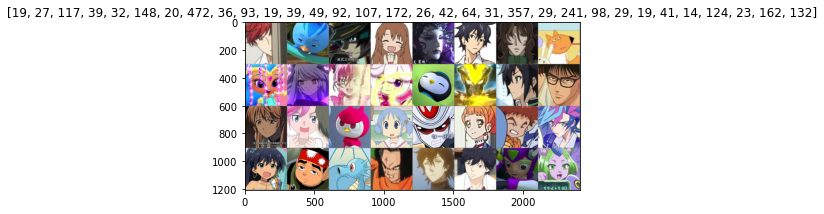

In [159]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloader_dict['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[num_image_in_class[x] for x in classes])

## Training

In [168]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Training Loop

In [250]:
def train_loop_save(model, criterion, optimizer, scheduler, epochs, dataloader_dict):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(epochs):
        print(f'Epoch {epoch}/{epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloader_dict[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    if phase == 'train':
                        outputs, aux_outputs = model(inputs)
                    else:
                        outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels) # loss function

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            # print(f'{phase} Loss: {epoch_loss:.4f}')

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), 'googlenet_weights.pth')
    return model

In [243]:
def train_loop(model, criterion, optimizer, scheduler, epochs, dataloader_dict):
    for epoch in range(epochs):
        train_loss = 0
        val_loss = 0
        accuracy = 0

        # Training the model
        model.train()
        counter = 0
        for inputs, labels in tqdm(dataloader_dict['train']):
            # Move to device
            inputs, labels = inputs.to(device), labels.to(device)
            # Clear optimizers
            optimizer.zero_grad()
            # Forward pass
            output, aux_outputs = model(inputs)
            # Loss
            loss = criterion(output, labels)
            # Calculate gradients (backpropogation)
            loss.backward()
            # Adjust parameters based on gradients
            optimizer.step()
            # Add the loss to the training set's rnning loss
            train_loss += loss.item()*inputs.size(0)

            # Print the progress of our training
            # counter += 1
            # print(counter, "/", len(dataloader_dict['train']))

        # Evaluating the model
        model.eval()
        counter = 0
        # Tell torch not to calculate gradients
        with torch.no_grad():
            for inputs, labels in tqdm(dataloader_dict['test']):
                # Move to device
                inputs, labels = inputs.to(device), labels.to(device)
                # Forward pass
                output = model(inputs)
                # Calculate Loss
                valloss = criterion(output, labels)
                # Add loss to the validation set's running loss
                val_loss += valloss.item() * inputs.size(0)

                # Since our model outputs a LogSoftmax, find the real 
                # percentages by reversing the log function
                output = torch.exp(output)
                # Get the top class of the output
                top_p, top_class = output.topk(1, dim=1)
                # See how many of the classes were correct?
                equals = top_class == labels.view(*top_class.shape)
                # Calculate the mean (get the accuracy for this batch)
                # and add it to the running accuracy for this epoch
                accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

                # Print the progress of our evaluation
                # counter += 1
                # print(counter, "/", len(dataloader_dict['test']))
                
        # scheduler.step()

        # Get the average loss for the entire epoch
        train_loss = train_loss/len(dataloader_dict['train'].dataset)
        valid_loss = val_loss/len(dataloader_dict['test'].dataset)
        # Print out the information
        print('Accuracy: ', accuracy / len(dataloader_dict['test']))
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))

### Define Loss Function

In [170]:
class AngularPenaltySMLoss(nn.Module):

    def __init__(self, in_features, out_features, loss_type='arcface', eps=1e-7, s=None, m=None):
        '''
        Angular Penalty Softmax Loss
        Three 'loss_types' available: ['arcface', 'sphereface', 'cosface']
        These losses are described in the following papers: 
        
        ArcFace: https://arxiv.org/abs/1801.07698
        SphereFace: https://arxiv.org/abs/1704.08063
        CosFace/Ad Margin: https://arxiv.org/abs/1801.05599
        '''
        super(AngularPenaltySMLoss, self).__init__()
        loss_type = loss_type.lower()
        assert loss_type in  ['arcface', 'sphereface', 'cosface']
        if loss_type == 'arcface':
            self.s = 64.0 if not s else s
            self.m = 0.5 if not m else m
        if loss_type == 'sphereface':
            self.s = 64.0 if not s else s
            self.m = 1.35 if not m else m
        if loss_type == 'cosface':
            self.s = 30.0 if not s else s
            self.m = 0.4 if not m else m
        self.loss_type = loss_type
        self.in_features = in_features
        self.out_features = out_features
        self.fc = nn.Linear(in_features, out_features, bias=False)
        self.eps = eps

    def forward(self, x, labels):
        '''
        input shape (N, in_features)
        '''
        assert len(x) == len(labels)
        assert torch.min(labels) >= 0
        assert torch.max(labels) < self.out_features
        
        for W in self.fc.parameters():
            W = F.normalize(W, p=2, dim=1)

        x = F.normalize(x, p=2, dim=1)

        wf = self.fc(x)
        if self.loss_type == 'cosface':
            numerator = self.s * (torch.diagonal(wf.transpose(0, 1)[labels]) - self.m)
        if self.loss_type == 'arcface':
            numerator = self.s * torch.cos(torch.acos(torch.clamp(torch.diagonal(wf.transpose(0, 1)[labels]), -1.+self.eps, 1-self.eps)) + self.m)
        if self.loss_type == 'sphereface':
            numerator = self.s * torch.cos(self.m * torch.acos(torch.clamp(torch.diagonal(wf.transpose(0, 1)[labels]), -1.+self.eps, 1-self.eps)))

        excl = torch.cat([torch.cat((wf[i, :y], wf[i, y+1:])).unsqueeze(0) for i, y in enumerate(labels)], dim=0)
        denominator = torch.exp(numerator) + torch.sum(torch.exp(self.s * excl), dim=1)
        L = numerator - torch.log(denominator)
        return -torch.mean(L)

### Start Training

In [253]:
args = AttrDict()
args_dict = {
    'image_size': 299,  # 256
    'crop_size': 299,  # 224
    'flip_prob': 0.3,
    'batch_size': 32,
    'num_workers': 2,
    'epochs': 50,
    'lr': 1e-3,
    'model': 'GoogLeNet',
    'loss_function': 'CrossEntropyLoss', # 'CrossEntropyLoss', 'arcface', 'sphereface', 'cosface'
    'optimizer': 'Adam',  # 'Adam', 'SGD'
    'step_size': 7,  # for learning rate scheduler
    'gamma': 0.1  # for learning rate scheduler
}

args.update(args_dict)
print("Loading dataset...")
dataloader_dict = get_anime_loader(args)

Loading dataset...
dataset_sizes = {'train': 311754, 'test': 77924}
Total number of images = 389678


In [248]:
def train(opts):
    train_model, criterion, optimizer, scheduler = None, None, None, None
    
    if opts.model == 'GoogLeNet':
        train_model = models.inception_v3(pretrained=True)
    else:
        train_model = models.resnet50(pretrained=True)
    
    for param in train_model.parameters():
        param.requires_grad = False
        
    num_in_features = train_model.fc.in_features
    
    # Handle the auxilary net
    aux_num_ftrs = train_model.AuxLogits.fc.in_features
    train_model.AuxLogits.fc = nn.Linear(aux_num_ftrs, num_classes)
    
    # Handle the primary net
    primary_num_ftrs = train_model.fc.in_features
    train_model.fc = nn.Linear(primary_num_ftrs, num_classes)
    
    if opts.loss_function == 'CrossEntropyLoss':
        train_model.fc = nn.Linear(num_in_features, num_classes)
        criterion = nn.CrossEntropyLoss()
    else:
        train_model.fc = nn.Linear(num_in_features, num_classes)
        criterion = AngularPenaltySMLoss(num_in_features, num_classes, loss_type=opts.loss_function)
        
    if opts.optimizer == 'SGD':
        optimizer = optim.SGD(train_model.parameters(), lr=opts.lr, momentum=0.9)
    else:
        optimizer = optim.Adam(train_model.parameters(), lr=opts.lr, betas=(0.9, 0.999), eps=1e-08)
    
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=opts.step_size, gamma=opts.gamma)
    
    # move model to GPU
    train_model = train_model.to(device)
    print(f"Model moved to GPU: {device}")
    
    train_loop_save(train_model, criterion, optimizer, scheduler, opts.epochs, dataloader_dict)

In [254]:
print_opts(args)
train(args)

                                      Opts                                     
-------------------------------------------------------------------------------
                             image_size: 299                                   
                              crop_size: 299                                   
                              flip_prob: 0.3                                   
                             batch_size: 32                                    
                            num_workers: 2                                     
                                 epochs: 50                                    
                                     lr: 0.001                                 
                                  model: GoogLeNet                             
                          loss_function: CrossEntropyLoss                      
                              optimizer: Adam                                  
                              step_size:

  1%|          | 72/9743 [00:27<1:01:44,  2.61it/s]


KeyboardInterrupt: 

In [17]:
def plot_training_curve_loss(train_losses, valid_losses, save_path):
    plt.figure()
    plt.plot(train_losses, "ro-", label="Train")
    plt.plot(valid_losses, "go-", label="Validation")
    plt.legend()
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.savefig(save_path + "/resnet_scratch_training_curve_loss.jpg")

    
def plot_training_curve_acc(train_acc, valid_acc, save_path):
    plt.figure()
    plt.plot(train_acc, "ro-", label="Train")
    plt.plot(valid_acc, "go-", label="Validation")
    plt.legend()
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.savefig(save_path + "/resnet_scratch_training_curve_acc.jpg")

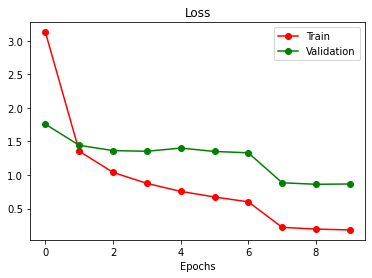

In [12]:
# resnet pretrained
plot_training_curve_loss([3.1277, 1.3545, 1.0390, 0.8754, 0.7562, 0.6730, 0.6004, 0.2205, 0.1942, 0.1821],
                         [1.7570, 1.4428, 1.3641, 1.3541, 1.4017, 1.3514, 1.3315, 0.8846, 0.8622, 0.8664], "plots")

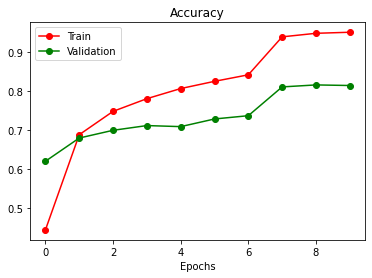

In [16]:
# resnet pretrained
plot_training_curve_acc([0.4441, 0.6879, 0.7477, 0.7802, 0.8061, 0.8246, 0.8413, 0.9385, 0.9476, 0.9503],
                        [0.6199, 0.6794, 0.6992, 0.7113, 0.7086, 0.7282, 0.7366, 0.8103, 0.8154, 0.8139], "plots")

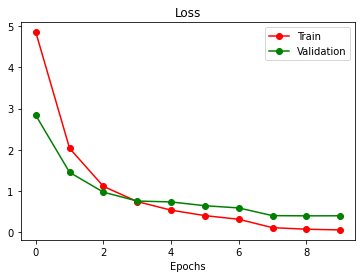

In [14]:
# resnet scratch
plot_training_curve_loss([4.8533, 2.0313, 1.1084, 0.7387, 0.5300, 0.3982, 0.3088, 0.1052, 0.0673, 0.0503],
                         [2.8345, 1.4479, 0.9672, 0.7521, 0.7302, 0.6383, 0.5843, 0.3973, 0.3923, 0.3936], "plots")

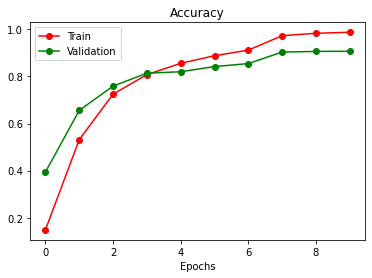

In [18]:
plot_training_curve_acc([0.1480, 0.5314, 0.7245, 0.8078, 0.8557, 0.8881, 0.9118, 0.9732, 0.9834, 0.9878],
                        [0.3935, 0.6558, 0.7588, 0.8139, 0.8200, 0.8419, 0.8547, 0.9036, 0.9063, 0.9070], "plots")